In [ ]:
#import packages
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import matplotlib as mpl
from pylab import cm

## Steps for simulating continuum radio sky map:
### Step1:
    Goal: package a particular halo catalog into a dictionary that can easily get wanted message.
    Input: halo catalog file
    Return: a dictionary with keys including: location( in spherical coordinates), redshift, number, subhalo. halovolume, and so on.
    
    1.From halo catalog get location, velocity, number, subhalos and some other nesessary data.
    2.Cut the centrol boll out and transfer every location data into spherical coordinates.
    3.Transfer into z space using velocity information.
    4.Return a dictionary
### Step2:
    Goal: make a function that can simulate the galaxies with a particular number in each halo in a z slice and a L bin and a nu bin.
    AGN: 
    Input: nu(MHz), parameter_list, Luminocity, z, **(nu_bin, z_bin, L_bin)
    Return: numbers of galaxies in each halo with particular location data
    
    1.Make nesessary funcions( LF, Numbercounts, L(z), S(nu)).
    2.Count the number density using luminocity function
    3.Cut the space into some small solid angles, each solid angle related to a small volume. Count the total number for this small volume. For each solid angle, give each halo a number of galaxies that is related to its halo mass, and with a total galaxies number counted before.
    4.Give each halo a fluctuation of number counts, without changing the total number counts.
    5.For each solid angle, each redshift bin, do the same thing mentioned before. 
    6.Rerurn the new array that include number counts and locations.
    7.Draw the picture in healpix way.
### Step3:( can skip it at first)
    Goal:seperate the galaxies
    Input: none
    Return: every galaxies' location
    
    1.For every halo, make an array with length equal to the number of galaxies in it.
    2.Give them a random location within the halo volume.
    3.Do the same thing to each halo, append the array.
    4.Return the array
    5.Draw the picture.
### Step4:
    Goal:Add all luminocites in a total map
    Input:Luminocity_min, Luminocity_max, Luminocity_bin
    Return:All luminocity, all locations
    
    1.Count all luminocity bin using method mentioned before.
    2.Make a big array, to hold total luminocity information. That is to say, add all arrays into a whole array, each with a particular luminocity.
    3.Return this big array
    4.Draw picture. You can see a huge amount of points, each shows to a galaxy, with a particular luminocity.
### Step5:
    Goal:Make the final function, that input a nu can return a galaxy simulation array. And give some statistical information.
    Input: nu,*nu_bin
    Return: galaxy simulation array, picture, and so on
    
    1.Conclude code typed before in to a function
    2.Draw pictures and do statistic analysis and compare these with observertory data.
### Step6:
    Goal: Advanced correlation...
    

## Step1:package a particular halo catalog into a dictionary that can easily get wanted message.

In [2]:
def get_data(filename,size = 200,content=[0,3,44,45,46]):    
    '''
    get_data(filename,size=200)\n
    size = 200Mpc\n
    content includes :#ID(1)	hostHalo(2)	numSubStruct(3)	Mvir(4)	npart(5)	Xc(6)	Yc(7)\n
    Zc(8)	VXc(9)	VYc(10)	VZc(11)	Rvir(12)	Rmax(13)	r2(14)	mbp_offset(15)\n	
    com_offset(16)	Vmax(17)	v_esc(18)	sigV(19)	lambda(20)	lambdaE(21)\n	
    Lx(22)	Ly(23)	Lz(24)	b(25)	c(26)	Eax(27)	Eay(28)	Eaz(29)	Ebx(30)	Eby(31)\n	
    Ebz(32)	Ecx(33)	Ecy(34)	Ecz(35)	ovdens(36)	nbins(37)	fMhires(38)	Ekin(39)\n	
    Epot(40)	SurfP(41)	Phi0(42)	cNFW(43)    R(44)    Theta(45)    Phi(46)    Z(47)\n
    if you don't type anything, it will return #ID(1), Mvir(4), Theta(45), Phi(46) and Z(47).

    1.From halo catalog get location, velocity, number, subhalos and some other nesessary data.\n
    2.Cut the centrol boll out and transfer every location data into spherical coordinates.\n
    3.Transfer into z space using velocity information.\n
    4.Return a 2Darray\n
    '''
    halocatalog = np.loadtxt(filename)
    num = np.size(halocatalog,0)

    #center the coordinates
    halocatalog[:,5] = halocatalog[:,5] - size*1000*0.5
    halocatalog[:,6] = halocatalog[:,6] - size*1000*0.5
    halocatalog[:,7] = halocatalog[:,7] - size*1000*0.5
    
    #transfer into spherical coordinates
    def appendspherical_np(x,y,z):
        r = np.sqrt(x**2+y**2+z**2)
        theta = np.arctan2(np.sqrt(x**2+y**2),z)
        phi = np.arctan2(y,x)
        return r, theta, phi
    RTPZ = np.zeros((num,4))
    for i in range(num):
        Xc = halocatalog[i,5]
        Yc = halocatalog[i,6]
        Zc = halocatalog[i,7]
        r,theta,phi = appendspherical_np(Xc,Yc,Zc)
        RTPZ[i,0] = r
        RTPZ[i,1] = theta
        RTPZ[i,2] = phi
        RTPZ[i,3] = r * H0 / c / 1000
    
    halocatalog = np.hstack((halocatalog,RTPZ))
    

    #get the data you want
    halo_want = halocatalog[:,content]
    halo_want_centrol = np.array(content)
    # cut the centrol ball out
    for i in range(num):
        if halocatalog[i][43]<= size*1000/2:
            halo_want_centrol = np.vstack((halo_want_centrol,halo_want[i]))
    return halo_want_centrol[1:,:]



# Step2: make a function that can simulate the galaxies with a particular number in each halo in a z slice and a S bin and a nu bin.

In [46]:
#1.Make nesessary funcions( LF, Numbercounts, L(z), S(nu)).

def logL_0(z, logLz, para):
    ''' 
    asume that logL(z) has the same evolution method as logL_star(z)\n
    but change the L dependent z_top into L independent
    input logLz, return logL0 for farther calculating
    '''
    k_evo = para['k_evo']
    z_top0 = para['z_top0']
    dz_top = para['dz_top']
    m_ev = para['m_ev']
    z_top = z_top0 + dz_top
    
    logL0 = logLz - (k_evo*z*(2*z_top - z**m_ev*z_top**(1-m_ev)/(1+m_ev)))
    return logL0

def logL_Sz(logS, z, para):
    ''' 
    S is the flux, with unit Jy(10^(-26)W/m^2Hz)\n
    z is redshift\n
    return logLz and logL0
    '''
    H0 = 67.77
    c = 299792.458
    logLz = np.log(4*np.pi*(z*c/H0*3.0836)**2*10**6)+logS
    logL0 = logL_0(z, logLz, para)
    return logLz, logL0

def logL_z(logL0, z, para):
    ''' 
    to calculate the logL(z) if we already know logL(0)\n
    logL(0) is dependent on what we expect to see in redshift z\', but we want to know how it evolute in the past time.
    input logL0, z **para
    return logL_z
    '''
    k_evo = para['k_evo']
    z_top0 = para['z_top0']
    dz_top = para['dz_top']
    m_ev = para['m_ev']
    z_top = z_top0 + dz_top
    
    logLz = logL0 + (k_evo*z*(2*z_top - z**m_ev*z_top**(1-m_ev)/(1+m_ev)))
    return logLz

def log_LF(logS, z, para):
    '''
    LF(logL_z, z, para)\n
    z is redshift.\n
    para is the parameter catalog of a particular type of galaxy. need to be a dictionary
    '''
    logn0 = para["logn0"]
    logL_star0 = para['logL*0']
    a = para['a']
    b = para['b']
    dz = 0.01
    logLz, logL0 = logL_Sz(logS, z, para)
    dlogL_z0 = logL_z(logL0, dz, para)-logL_z(logL0, 0, para)
    dlogL_z = logL_z(logL0, z+dz, para)-logL_z(logL0, z, para)
    part1 = logn0 - np.log(10**(a*(logL0-logL_star0))+10**(b*(logL0-logL_star0)))
    part2 = np.log(dlogL_z0) - np.log(dlogL_z)
    logPhi = part1 + part2
    return logPhi

#count the number density
def Numbercounts_in_box(logS, z, para, Omega=np.pi**2*0.02,deltaz=0.0001, deltalogS=0.1, Deltaz = 0.001):
    ''' 
    we expect to know the number of galaxies in a little box located at a particular z and solid angle.\n
    These contribute the same flux S with different luminosities depended on z.\n
    input S, z, para \n
    returen number of galaxies in this box contributing flux S
    '''
    z_range = np.arange(z, z+Deltaz, deltaz)
    N_z = 0
    for z_i in z_range:
        logPhi_z = log_LF(logS, z_i, para)
        dV = Omega*z_i**2*(c/H0)**3*deltaz #unit:Mpc^3
        dlogL = logL_Sz(logS+deltalogS, z_i+deltaz, para)[0]-logL_Sz(logS, z_i, para)[0]
        N_z += 10**logPhi_z*dV*dlogL
    return N_z
    
    

In [11]:
print(log_LF(-10.5, 0.0011, Parameter_BLLac)-log_LF(-11, 0.001, Parameter_BLLac))

-0.9954995472193966


In [19]:
'''
3.Cut the space into some small solid angles, each solid angle related to a small volume. 
Count the total number for this small volume. 
For each solid angle, give each halo a number of galaxies that is related to its halo mass, 
and with a total galaxies number counted before.
'''
def cut_space(halo, z, Theta, Phi, DeltaPhi=np.pi*0.2, DeltaTheta=np.pi*0.1, Deltaz=0.001):
    ''' 
    cut the little box out\n
    return a wanted box held halos
    '''
    halo_box = np.zeros(len(halo[0]))
    for i in range(len(halo[:,0])):
        if (halo[i][4]>= z) and (halo[i][4]< z + Deltaz) and (halo[i][2]>= Theta) and (halo[i][2]<Theta+DeltaTheta) and (halo[i][3]>=Phi) and (halo[i][3]<Phi+DeltaPhi):
            halo_box = np.vstack((halo_box,halo[i]))
        else:
            pass
    halo_box = np.delete(halo_box,0,0)
    return halo_box
    

#simulate galaxies numbers in one little box(with the number as a function of M)
def galaxy_simulate(halo_box, z, logS, para):
    ''' 
    return a new box with galaxies' numbers simulation
    '''
    number = Numbercounts_in_box(logS, z, para)
    M_total = sum(halo_box[:,1])
    galaxy_in_halo = np.array([0])
    for i in range(len(halo_box[:,0])):
        n_i = round(number*halo_box[i,1]/M_total)
        galaxy_in_halo = np.vstack((galaxy_in_halo, np.array([n_i])))
    galaxy_in_halo = np.delete(galaxy_in_halo,0)
    galaxy_in_halo = np.reshape(galaxy_in_halo,(len(galaxy_in_halo),1))
    halo_box = np.hstack((halo_box,galaxy_in_halo))
    return halo_box

#simulate galaxies numbers in one little box( with a random number)
def galaxy_simulate_random(halo_box, z, logS, para):

    number = round(Numbercounts_in_box(logS, z, para))
    number_of_people = len(halo_box[:,0])
    def generate_random_integers(n, m):
        if 
        integers = []
        for i in range(n - 1):
            # 生成一个随机正整数，范围在[1, m - n + 1]之间
            rand_int = random.randint(1, m - n + 1)
            integers.append(rand_int)
            m -= rand_int

        # 最后一个整数就是剩余的 m 值
        integers.append(m)

        # 打乱整数列表的顺序
        random.shuffle(integers)

        return integers
    galaxy = generate_random_integers(number, number_of_people)
    galaxy = np.reshape(np.array(galaxy),(number_of_people,1))
    halo_box = np.hstack((halo_box,galaxy))
    return halo_box


#simulate in whole sky under a particular S
def all_sky_simulate(halocatalog, logS, parameter,size=200,  DeltaPhi=2*np.pi*0.1, DeltaTheta=np.pi*0.1, Deltaz=0.001):
    ''' 
    return a whole array with numbers of galaxies in each halo
    '''
    H0 = 67.3
    c = 299792.458
    para = parameter
    #cut the space:
    Phi_range = np.arange(-np.pi, np.pi, DeltaPhi)
    Theta_range = np.arange(0,np.pi,DeltaTheta)
    z_max =  size/2 * H0 / c 
    Z_range = np.arange(Deltaz,z_max, Deltaz)
    halo_with_galaxy = np.zeros(len(halocatalog[0])+1)
    halo_box = 0
    for i in range(len(Phi_range)):
        phi = Phi_range[i]
        for j in range(len(Theta_range)):
            theta = Theta_range[j]
            for k in range(len(Z_range)):
                z = Z_range[k]
                halo_box = cut_space(halocatalog, z, theta, phi)
                if np.any(halo_box):
                    halo_box = galaxy_simulate(halo_box, z, logS, para )
                    halo_with_galaxy = np.vstack((halo_with_galaxy,halo_box))
                else:
                    pass
    halo_with_galaxy = np.delete(halo_with_galaxy,0,0)
    return halo_with_galaxy

    


In [13]:
#plot the healpix figure at a particular flux

def plot_hpx_flux(halo_with_galaxy, caption, unit):
    theta = halo_with_galaxy[:,2]
    phi = halo_with_galaxy[:,3]
    num = halo_with_galaxy[:,-1]
    def cat_to_hpx(theta,phi,nside,DATA):
        n=len(theta)
        npix=hp.nside2npix(nside)#总的像素
        indices=hp.ang2pix(nside,theta,phi)
        hpx_map=np.zeros(npix,dtype=float)
        for i in range(n):#将函数值在各自的地方生成出
            hpx_map[indices[i]]+=DATA[i]#重复的位置函数值累

        for i in range(npix):
            hpx_map[i]=np.log(hpx_map[i]+1)#总体压缩

        return hpx_map

    NSIDE=128
    hpx_map_z=cat_to_hpx(theta,phi,NSIDE,num)


    f=plt.figure(figsize=(13,10))
    hpix_area=round(41253/len(np.arange(hp.nside2npix(NSIDE),dtype=np.double)),1)
    mmin,mmax=min((hpx_map_z)),max((hpx_map_z))
    #作图设置
    cmap=cm.jet
    hp.mollview((hpx_map_z),hold=True,nest=False,cmap=cmap,min=mmin,max=mmax,notext=True,fig=1,cbar=False,title=caption)
    hp.graticule()
    cax=f.add_axes([0.125,0.1,0.775,0.03])
    cb=mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=mmin,vmax=mmax),orientation='horizontal')
    cb.set_label(unit)
    cb.solids.set_edgecolor('face')


    plt.show()


# Step4: Add all luminocites in a total map

In [35]:
''' 
1.Count all luminocity bin using method mentioned before.
    2.Make a big array, to hold total luminocity information. That is to say, add all arrays into a whole array, each with a particular luminocity.
    3.Return this big array
    4.Draw picture. You can see a huge amount of points, each shows to a galaxy, with a particular luminocity.
'''

def all_flux_count(halo_with_galaxy, logS_max, logS_min, para, DeltalogS = 0.1):
    logS_range = np.arange(logS_min, logS_max, DeltalogS)
    all_flux_galaxy = np.array([])
    for logS in logS_range:
        halo_with_galaxy_logS = all_sky_simulate(halocatalog, logS, para)
        rows = np.shape(halo_with_galaxy,0)
        logS_array = np.full()
        all_flux_galaxy["halo_with_galaxy"].append(halo_with_galaxy_logS)
    return all_flux_galaxy




In [36]:
#change a frequency, that every S transfer to another S, depend on the S-nu power law or others.
def logS_nu(nu2, logS1, alpha, nu1 = 1.4):
    sigma = 0.25
    beta = 0
    logS2 = (alpha - sigma**2*(1-beta)*np.ln(nu2/nu1))*np.log(nu2/nu1) + logS1
    return logS2

def change_frequency(nu2,all_flux_galaxy, para):
    alpha = para['alpha']
    for i in range(len(all_flux_galaxy["flux"])):
        logS1 = np.log(all_flux_count["flux"][i])
        all_flux_galaxy["flux"][i] = logS_nu(nu2, logS1, alpha)
    return all_flux_galaxy



# Running the code!

In [8]:
#parameter
Parameter_FSRQ={'a':0.776,'b':2.669,'logn0':-8.319,'logL*0':33.268,'k_evo':1.234,'z_top0':2.062,'dz_top':0.559,'m_ev':0.136,'alpha':-0.1}
Parameter_BLLac={'a':0.723,'b':1.918,'logn0':-7.165,'logL*0':32.282,'k_evo':0.206,'z_top0':1.262,'dz_top':0,'m_ev':1,'alpha':-0.1}
Parameter_SSAGN={'a':0.508,'b':2.545,'logn0':-5.973,'logL*0':32.560,'k_evo':1.349,'z_top0':1.116,'dz_top':0.705,'m_ev':0.253,'alpha':-0.8}

size = 200
H0 = 67.3
c = 299792.458
IDE_1_2_file = get_data('../IDE_1_2.txt')






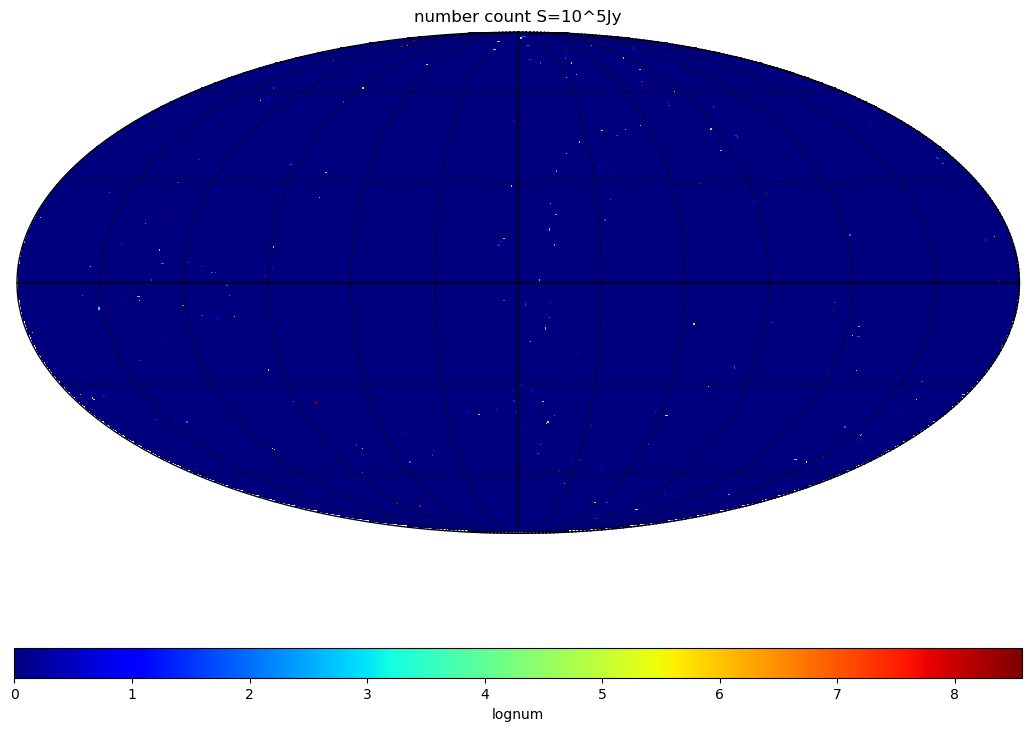

In [47]:
halo_with_galaxy_IDE12 = all_sky_simulate(IDE_1_2_file, 5, Parameter_FSRQ)
plot_hpx_flux(halo_with_galaxy_IDE12, 'number count S=10^5Jy','lognum')


In [55]:
print(np.mean(halo_with_galaxy_IDE12[:,-1]))

1186683.7936042529


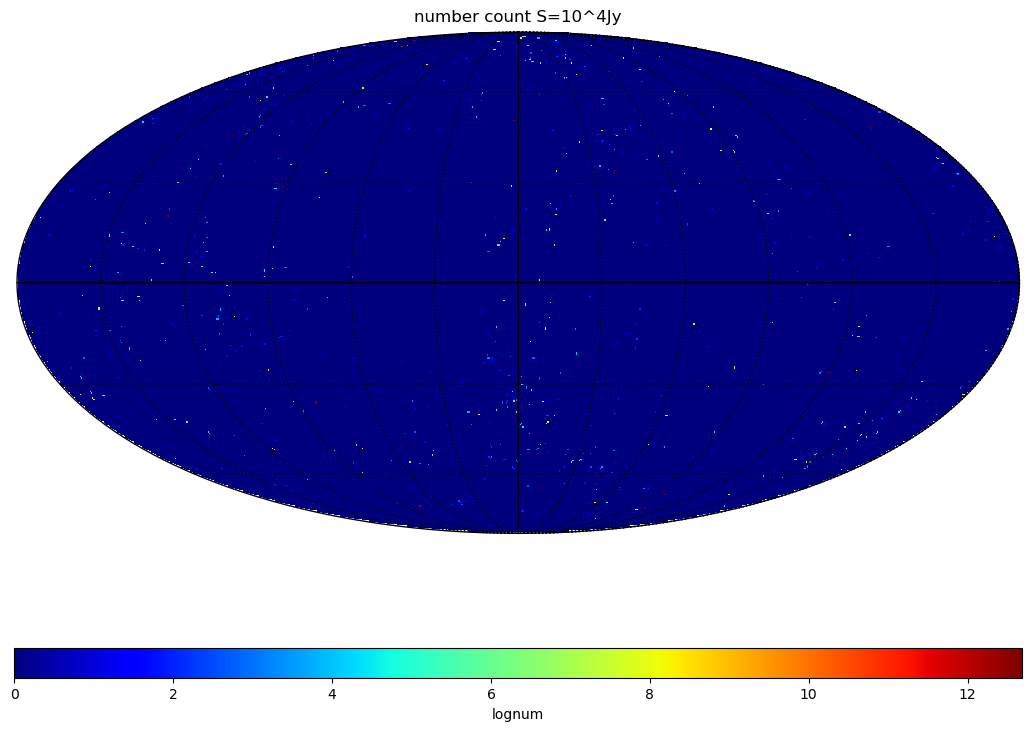

In [49]:
halo_with_galaxy_IDE12 = all_sky_simulate(IDE_1_2_file, 4, Parameter_FSRQ)
plot_hpx_flux(halo_with_galaxy_IDE12, 'number count S=10^4Jy','lognum')

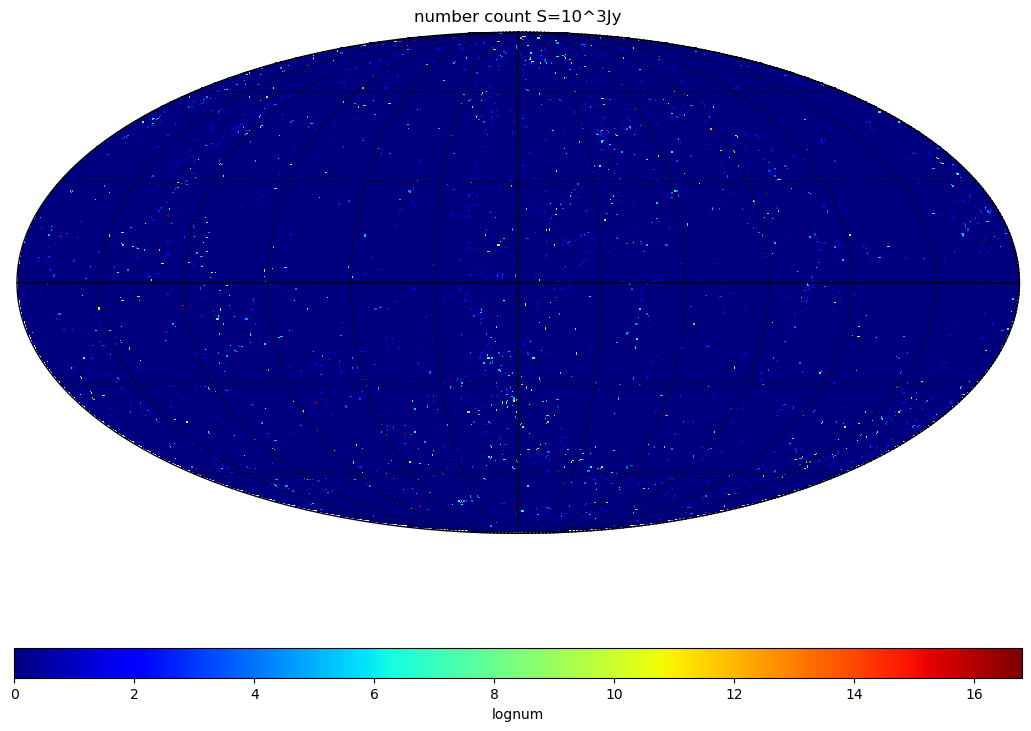

In [50]:
halo_with_galaxy_IDE12 = all_sky_simulate(IDE_1_2_file, 3, Parameter_FSRQ)
plot_hpx_flux(halo_with_galaxy_IDE12, 'number count S=10^3Jy','lognum')

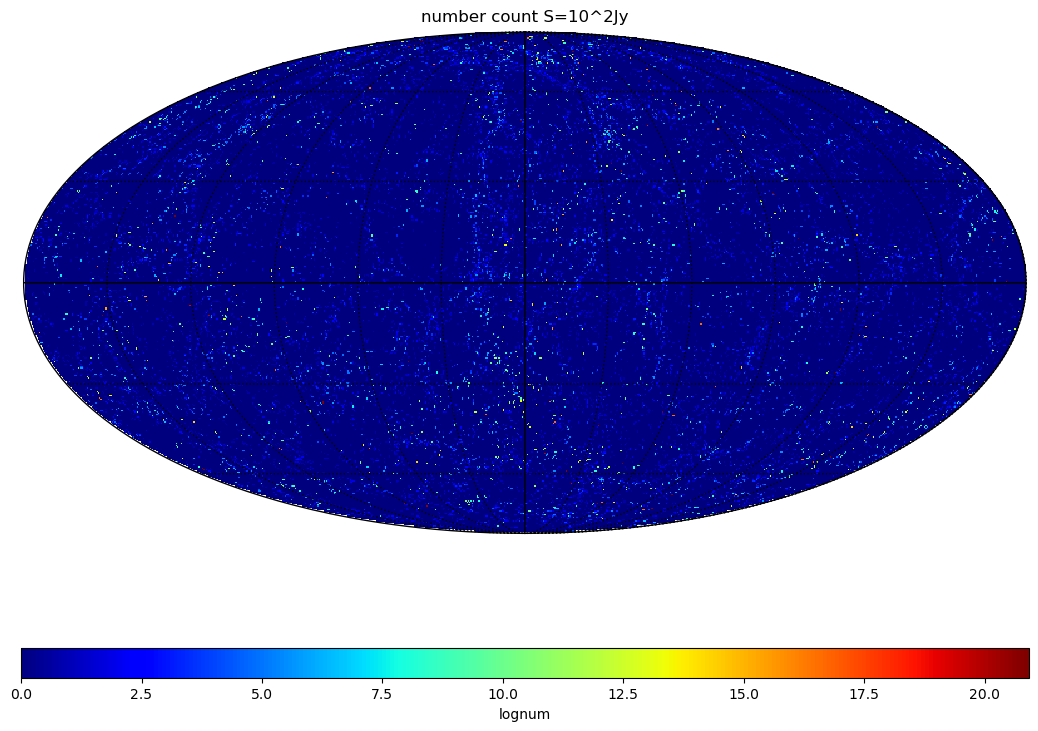

In [51]:
halo_with_galaxy_IDE12 = all_sky_simulate(IDE_1_2_file, 2, Parameter_FSRQ)
plot_hpx_flux(halo_with_galaxy_IDE12, 'number count S=10^2Jy','lognum')

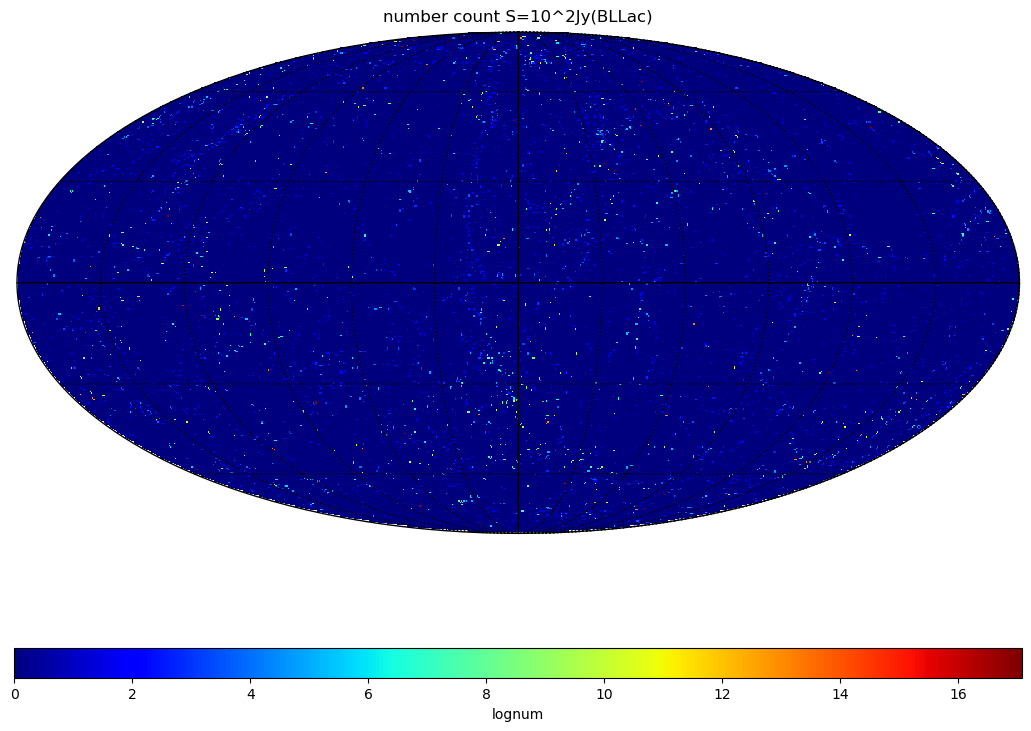

In [56]:
halo_with_galaxy_IDE12 = all_sky_simulate(IDE_1_2_file, 2, Parameter_BLLac)
plot_hpx_flux(halo_with_galaxy_IDE12, 'number count S=10^2Jy(BLLac)','lognum')

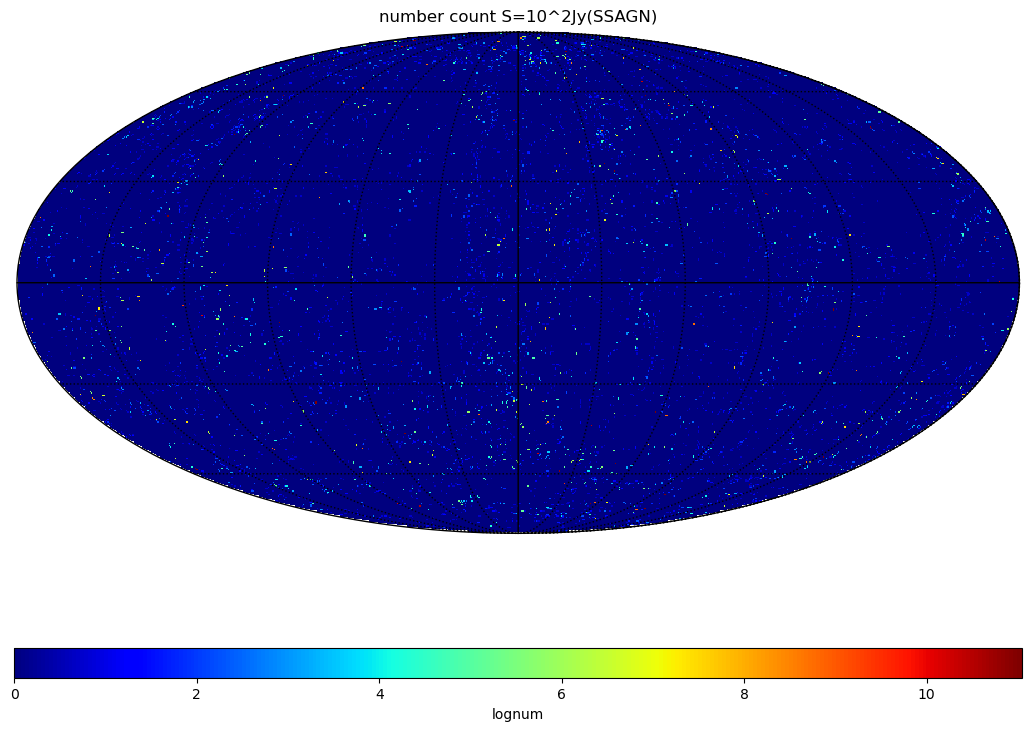

In [57]:
halo_with_galaxy_IDE12 = all_sky_simulate(IDE_1_2_file, 2, Parameter_SSAGN)
plot_hpx_flux(halo_with_galaxy_IDE12, 'number count S=10^2Jy(SSAGN)','lognum')